# Connected Component Analysis

Thresholding helps divides an image into forground and background pixels. Now the next step is going to be counting the object in an image which basically the distinct bright regions in a black background. \

A connected region is a region where you can get all 1's within one hop. You cannot hop diaonally. This is a one hop neighbourhood. \

A two hop neighbouhood is when you can reach all the 1s in 2 hops. (preferably diagonal hops) \ 
In this example:\
0 0 0 0 0 0 0 0 \
0 1 1 0 0 0 0 0 \
0 1 1 0 0 0 0 0 \
0 0 0 1 1 1 0 0 \
0 0 0 1 1 1 1 0 \
0 0 0 0 0 0 0 0 \
One hop neighbourhood would count two objects and two hop neighborhood would count one object.

Outputs an image with numeric identification tags. So the previous example basically becomes: \
0 0 0 0 0 0 0 0 \
0 1 1 0 0 0 0 0 \
0 1 1 0 0 0 0 0 \
0 0 0 2 2 2 0 0 \
0 0 0 2 2 2 2 0 \
0 0 0 0 0 0 0 0 

In [21]:
#import libraries
import skimage.io as skio
import matplotlib.pyplot as plt
import numpy as np
import skimage.color
import skimage.filters
import skimage.measure
import skimage.morphology

In [2]:
%matplotlib widget

In [9]:
# create a function to repeat analysis later on
def connected_components(filename, sigma = 1.0, t = 0.5, connectivity = 2):# connectivity parameter tells you about what kind of neighborhood (1/2/4/8)
    image = skio.imread(filename)
    gray_image = skimage.color.rgb2gray(image)
    blurred_image = skimage.filters.gaussian(gray_image, sigma = sigma)
    binary_mask = blurred_image < t
    plt.subplots()
    plt.imshow(binary_mask)
    labeled_image, count = skimage.measure.label(binary_mask, 
                                                 connectivity=connectivity, 
                                                 return_num=True)
    return labeled_image, count

In [4]:
labeled_image, count = connected_components(filename = "data/shapes-01.jpg", 
                                            sigma=2, 
                                            t=0.9, 
                                            connectivity=2)

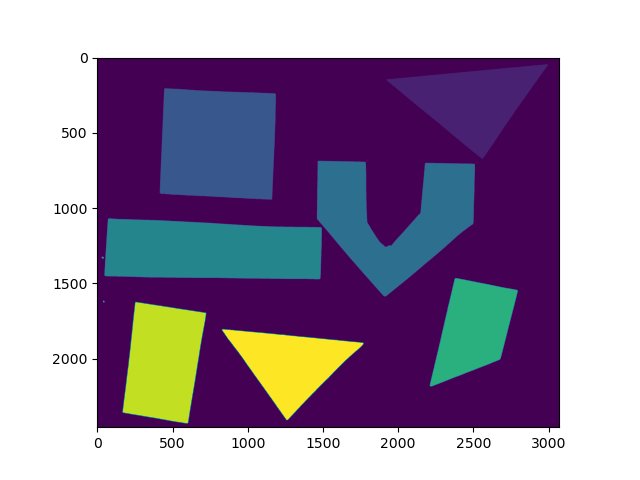

In [5]:
plt.subplots()
plt.imshow(labeled_image)

In [6]:
print(count)

11


Background is considered 0. There are 7 shapes. So the count should 8 but the result is 11. The extra colors are because of the extra dots which could basically be noise. One way to get over it is by blurring more. The other way is to increasing the threshold value.

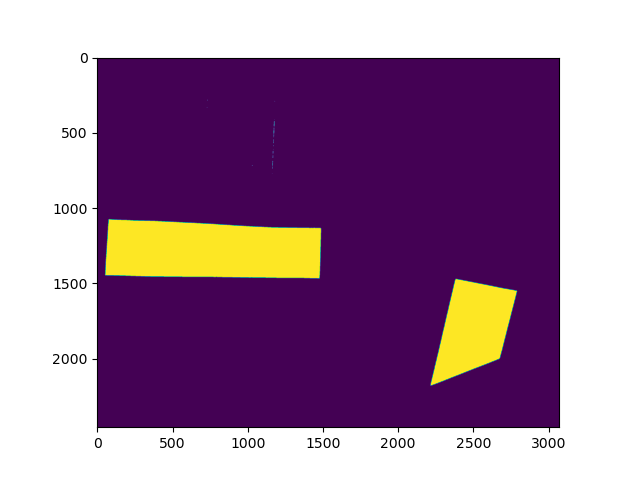

In [10]:
labeled_image, count = connected_components(filename = "data/shapes-01.jpg", 
                                            sigma=2, 
                                            t=0.5, 
                                            connectivity=2)

In [8]:
print(count)

20


20! That definitely doesn't look right! So we go back and edit the function to print the binary mask. And it can be seen that there is an edge there that has been added. If the thresholding value is too much, then we end up covering a lot of data that we actually needed but there are these edges that kind of stick around as they are connected to these bright areas.

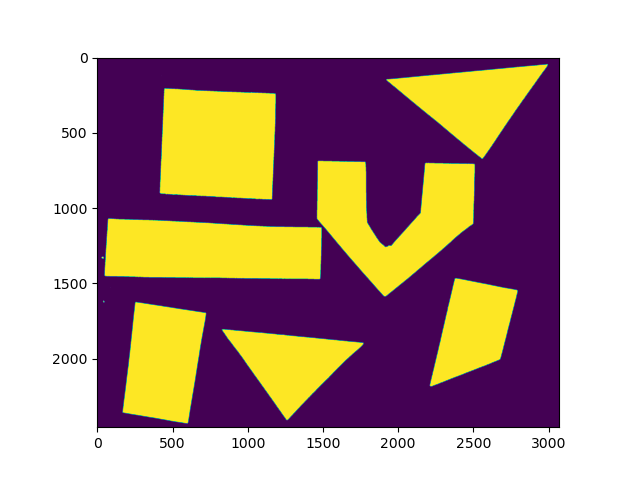

In [11]:
labeled_image, count = connected_components(filename = "data/shapes-01.jpg", 
                                            sigma=2, 
                                            t=0.9, 
                                            connectivity=2)

In [12]:
labeled_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
object_features = skimage.measure.regionprops(labeled_image)
object_features

In [14]:
skimage.measure.regionprops?

Signature:
skimage.measure.regionprops(
    label_image,
    intensity_image=None,
    cache=True,
    coordinates=None,
    *,
    extra_properties=None,
)
Docstring:
Measure properties of labeled image regions.

Parameters
----------
label_image : (M, N[, P]) ndarray
    Labeled input image. Labels with value 0 are ignored.

    .. versionchanged:: 0.14.1
        Previously, ``label_image`` was processed by ``numpy.squeeze`` and
        so any number of singleton dimensions was allowed. This resulted in
        inconsistent handling of images with singleton dimensions. To
        recover the old behaviour, use
        ``regionprops(np.squeeze(label_image), ...)``.
intensity_image : (M, N[, P][, C]) ndarray, optional
    Intensity (i.e., input) image with same size as labeled image, plus
    optionally an extra dimension for multichannel data. Currently,
    this extra channel dimension, if present, must be the last axis.
    Default is None.

    .. versionchanged:: 0.18.0
        Th

In [16]:
object_areas = [feat["area"] for feat in object_features]

In [17]:
object_areas

[318542, 1, 523204, 496613, 517331, 143, 256215, 1, 68, 338784, 265755]

Text(0, 0.5, 'Number of objects')

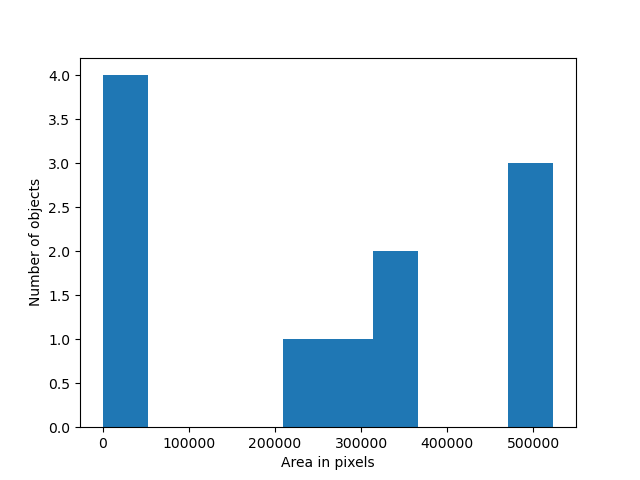

In [18]:
plt.subplots()
plt.hist(object_areas)
plt.xlabel("Area in pixels")
plt.ylabel("Number of objects")

So basically we don't care about anything that is less than 100000 and greater than 500000. These are either the noise particles or the background area.

In [19]:
# Filter by area
min_area = 100000
large_objects = []
for features in object_features:
    if features["area"] > min_area:
        large_objects.append(features["label"])
print(len(large_objects))

7


This returns 7 because the skimage.measures library skips over the 0 label which is the background so we don't specifically include it here. This does not hold true for all libraries just the skimage.

In [20]:
def enhanced_connected_components(filename, sigma=1.0, t=0.5, connectivity=2, min_area=0):
    '''
    Doing this the manual way:
    1. Do normal CCA as per connected_components()
    2. Use morphometrics to calculate object areas
    3. Strat a blank mask full of True pixeks
    4. Loop over each morphometric object:
        if the area is too small, sraw it on the mask (set to False)
    5. Combine small object mask with old threshold mask using (mask1 & mask2)
    6. Redo CCA using that new, combined mask
    
    OR
    Using the skimage tools to do it for us
    '''
    image = skio.imread(filename)
    gray_image = skimage.color.rgb2gray(image)
    blurred_image = skimage.filters.gaussian(gray_image, sigma = sigma)
    binary_mask = blurred_image < t
    
    object_mask = skimage.morphology.remove_small_objects(binary_mask, min_area)
    labeled_image, count = skimage.measure.label(object_mask, connectivity=connectivity, return_num=True)
    return labeled_image, count

In [24]:
labeled_image, count = enhanced_connected_components(filename = "data/shapes-01.jpg", 
                                            sigma=2, 
                                            t=0.9, 
                                            connectivity=2,
                                             min_area=200)
print(count)

7


#### Color Mapping

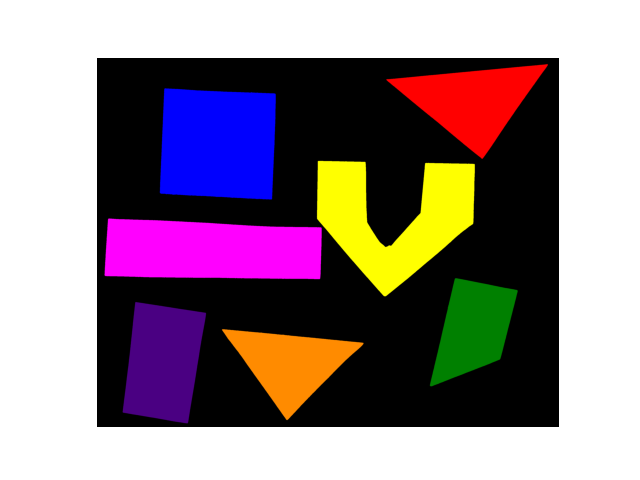

In [25]:
# convert the label image to color image
colored_label_image = skimage.color.label2rgb(labeled_image, bg_label=0)

fig, ax = plt.subplots()
plt.imshow(colored_label_image)
plt.axis("off");

#### Color Objects by area

In [27]:
object_areas = np.array([objf["area"] for objf in skimage.measure.regionprops(labeled_image)])

In [28]:
object_areas

array([318542, 523204, 496613, 517331, 256215, 338784, 265755])

In [29]:
object_areas = np.insert(0,1,object_areas) #add a value for the background area - usefule to find out proportion/density
object_areas

array([     0, 318542, 523204, 496613, 517331, 256215, 338784, 265755])

In [30]:
labeled_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [32]:
colored_area_image = object_areas[labeled_image]
colored_area_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

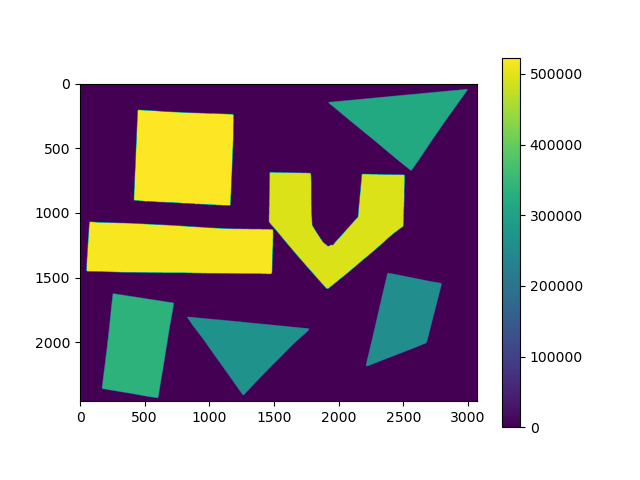

In [33]:
plt.figure()
plt.imshow(colored_area_image)
plt.colorbar()